In [2]:
%tensorflow_version 2.x

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
# tf.config.experimental.set_visible_devices(devices=gpus[0], device_type="GPU")
# tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

Num GPUs Available:  1
Executing op MatMul in device /job:localhost/replica:0/task:0/device:CPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [ ]:
# %pip install tqdm opencv-contrib-python pandas numpy albumentations

In [ ]:
tf.device('/job:localhost/replica:0/task:0/device:XLA_GPU:0')
tf.config.optimizer.set_jit(True) 

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [ ]:
tf.debugging.set_log_device_placement(False)


In [5]:
 ! unzip drive/My\ Drive/CelebAMask-HQ.zip
# ! rm -rf CelebAMask-HQ/CelebAMask-HQ-mask/*
# ! ls -l  CelebAMask-HQ/CelebAMask-HQ-mask/ |wc -l

Streaming output truncated to the last 5000 lines.
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_neck.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_nose.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_r_brow.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_r_eye.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_skin.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_u_lip.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_hair.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_l_brow.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_l_eye.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_l_lip.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_mouth.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_neck.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_nose.png  
  inflating: CelebAMask-HQ/Cel

In [ ]:
dataset_path = 'CelebAMask-HQ'


In [30]:
import os
import tensorflow as tf
import cv2
import glob
import numpy as np
import tqdm

In [6]:


label_list = ['skin', 'nose', 'eye_g', 'l_eye', 'r_eye', 'l_brow', 'r_brow', 'l_ear', 'r_ear', 'mouth', 'u_lip', 'l_lip', 'hair', 'hat', 'ear_r', 'neck_l', 'neck', 'cloth']

folder_base = 'CelebAMask-HQ/CelebAMask-HQ-mask-anno'
folder_save = 'CelebAMask-HQ/CelebAMask-HQ-mask'
img_num = 30000

label_needed = ['u_lip', 'l_lip','l_eye', 'r_eye']
if not os.path.exists(folder_save):
  os.mkdir(folder_save)

for k in tqdm.tqdm(range(img_num)):
    folder_num = k // 2000
    im_base = np.zeros((512, 512))
    for idx, label in enumerate(label_needed):
        filename = os.path.join(folder_base, str(folder_num), str(k).rjust(5, '0') + '_' + label + '.png')
        if (os.path.exists(filename)):
            # print (label, idx+1)
            im = cv2.imread(filename)
            im = im[:, :, 0]
            im_base[im != 0] = 1

    filename_save = os.path.join(folder_save, str(k) + '.png')
    # print (filename_save)
    cv2.imwrite(filename_save, im_base)

100%|██████████| 30000/30000 [05:42<00:00, 87.65it/s]


In [31]:

images = sorted(glob.glob("CelebAMask-HQ/CelebA-HQ-img/*"))
masks = sorted(glob.glob(os.path.join('CelebAMask-HQ/CelebAMask-HQ-mask', "*")))


In [ ]:
images[200],masks[200]

('CelebAMask-HQ/CelebA-HQ-img/10177.jpg',
 'CelebAMask-HQ/CelebAMask-HQ-mask/10177.png')

In [ ]:
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip

def augment_data(images, masks, augment=True):
    H = 512
    W = 512
    
    for x, y in tqdm.tqdm(zip(images, masks), total=len(images)):
        name = x.split("/")[-1].split(".")
        save_path_img = "CelebAMask-HQ/aug_in/"
        save_path_mask= "CelebAMask-HQ/aug_mask/"
        """ Extracting the name and extension of the image and the mask. """
        image_name = name[0]
        image_extn = name[1]

        name = y.split("/")[-1].split(".")
        mask_name = name[0]
        mask_extn = name[1]

        """ Reading image and mask. """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_COLOR)

        """ Augmentation """
        if augment == True:
            aug = CenterCrop(H, W, p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]

            aug = RandomRotate90(p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented['image']
            y2 = augmented['mask']

            aug = GridDistortion(p=1.0)
            augmented = aug(image=x, mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']

            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']

            aug = VerticalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x5 = augmented['image']
            y5 = augmented['mask']

            save_images = [x, x1, x2, x3, x4, x5]
            save_masks =  [y, y1, y2, y3, y4, y5]

        else:
            save_images = [x]
            save_masks = [y]

        """ Saving the image and mask. """
        idx = 0
        for i, m in zip(save_images, save_masks):
            im_base = np.zeros((512, 512))
            i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))
            m = m[:, :, 0]
            im_base[m != 0] = 1
#             print(im_base.shape)
            if len(images) == 1:
                tmp_img_name = f"{image_name}.{image_extn}"
                tmp_mask_name = f"{mask_name}.{mask_extn}"
            else:
                tmp_img_name = f"{image_name}_{idx}.{image_extn}"
                tmp_mask_name = f"{mask_name}_{idx}.{mask_extn}"
            
            image_path = os.path.join(save_path_img, tmp_img_name)
            mask_path = os.path.join(save_path_mask, tmp_mask_name)
              
            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, im_base)

            idx += 1


In [ ]:
augment_data(images[:10000], masks[:10000])

100%|██████████| 10000/10000 [11:20<00:00, 14.69it/s]


In [32]:
num_images = 5000 


In [33]:

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image , ImageOps

input_x = []
output_y = []

image_size = (128,128)
image_dir_x = 'CelebAMask-HQ/CelebA-HQ-img'
image_dir_y = 'CelebAMask-HQ/CelebAMask-HQ-mask'

x_filenames = os.listdir( image_dir_x )
# y_filenames = os.listdir( image_dir_y )
x_filenames = [name for name in x_filenames if '_1.jpg' not in  name]
for filename in tqdm.tqdm(x_filenames[:num_images]):
    image_x = Image.open(os.path.join(image_dir_x, filename))
    image_y = Image.open(os.path.join(image_dir_y, filename.replace('.jpg','.png')))
    input_x.append(np.asarray(image_x.resize(image_size)))
    output_y.append(np.asarray(image_y.resize(image_size)))

input_x = np.array(input_x)/255
output_y = np.array(output_y) #/255






100%|██████████| 5000/5000 [02:07<00:00, 39.27it/s]


In [34]:
train_features, test_features, train_labels, test_labels = train_test_split(np.array(input_x), np.array(output_y),
																					test_size=0.2)

In [ ]:
len(x_filenames)

50000

In [35]:
train_labels[3].shape , train_features[3].shape

((128, 128), (128, 128, 3))

In [100]:
def show_images(images: list):
    n = len(images)
    f = plt.figure()
    plt.imshow(images[0])
    plt.imshow(images[1], alpha=0.5)
    
    plt.show()

In [15]:
x_filenames[20060]

'22087.jpg'

In [ ]:
# id = 21
# show_images( [ train_features[id] , train_labels[id].reshape((128, 128))] )


In [37]:
train_labels = np.expand_dims(train_labels, axis=3)
test_labels = np.expand_dims(test_labels, axis=3) 


In [60]:
train_labels[0].shape

(128, 128, 1)

In [39]:



train_dataset = tf.data.Dataset.from_tensor_slices( ( train_features , train_labels ) )
train_dataset = train_dataset.shuffle( 1024 ).batch( batch_size )
test_dataset = tf.data.Dataset.from_tensor_slices( ( test_features , test_labels ) )
test_dataset = test_dataset.shuffle( 1024 ).batch( batch_size )

Calculating Output Size
O=(W−K−2P)/S + 1 
* O is the output height/length
* W is the input height/length
* K is the filter size
* P is the padding
    * "same" = -1
    * "valid" = 0
* S is the stride

In [ ]:
# tf.data.experimental.save(train_dataset, './train_data')
# tf.data.experimental.save(test_dataset, './test_data')


In [ ]:
# train_dataset = tf.data.experimental.load('./train_data',tf.TensorSpec(shape=(32,128,128,3), dtype=tf.float64))
# test_dataset = tf.data.experimental.load('./test_data',tf.TensorSpec(shape=(32,128,128), dtype=tf.float64))

In [141]:
"""
HYPERPARAMETERS
"""

"""
input = [batch, height, width,in_channels] 
filter = [height,width, output_channels, in_channels].
"""
batch_size = 32
relu_alpha = 0.2
dropout_rate = 0.5
padding = "SAME"
learning_rate = "0.0001"  #param [ "0.1" , "0.001" , "0.0001" , "0.05" ]
epochs = 30
shapes = [
    [ 3 , 3 , 3 , 16 ] , 
    [ 3 , 3 , 16 , 16 ] , 

    [ 3 , 3 , 16 , 32 ] , 
    [ 3 , 3 , 32 , 32 ] ,

    [ 3 , 3 , 32 , 64 ] , 
    [ 3 , 3 , 64 , 64 ] ,

    [ 3 , 3 , 64 , 128 ] , 
    [ 3 , 3 , 128 , 128 ] ,

    [ 3 , 3 , 128 , 256 ] , 
    [ 3 , 3 , 256 , 256 ] ,

    [ 3 , 3 , 128 , 256 ],
    [ 3 , 3 , 128 , 256 ],

    [ 3 , 3 , 64 , 128 ],
    [ 3 , 3 , 64 , 128 ],

    [ 3 , 3 , 32 , 64],
    [ 3 , 3 , 32 , 64 ],

    [ 3 , 3 , 16 , 32 ],
    [ 3 , 3 , 16 , 32 ],

    [ 3 , 3 , 16 , 1 ],
]


initializer = tf.initializers.glorot_uniform()
def get_weight( shape , name ):
    return tf.Variable( initializer( shape ) , name=name , trainable=True )

weights = []
for i in range( len( shapes ) ):
    weights.append( get_weight( shapes[ i ] , 'weight{}'.format( i ) ) )

In [142]:
def conv2d_down(x,filters,stride_size):
  y = tf.nn.conv2d(x,filters,strides=stride_size,padding=padding)
  return tf.nn.leaky_relu(y,alpha = relu_alpha )
  
def maxpool_down(x,pool_size,stride_size):
  return tf.nn.max_pool(x,ksize=pool_size,padding='VALID',strides=stride_size)

def conv2d_up(x,filters,stride_size,output_shape):
  y = tf.nn.conv2d_transpose(x,filters,output_shape=output_shape,strides=stride_size,padding=padding)
  return tf.nn.leaky_relu(y,alpha = relu_alpha )

def maxpool_up(x,size):
  x_dimen  = tf.shape(x)[1]
  y_dimen = tf.cast( tf.round( x_dimen * size ) , dtype=tf.int32 )
  return tf.image.resize(x , [y_dimen, y_dimen] ,method='nearest')



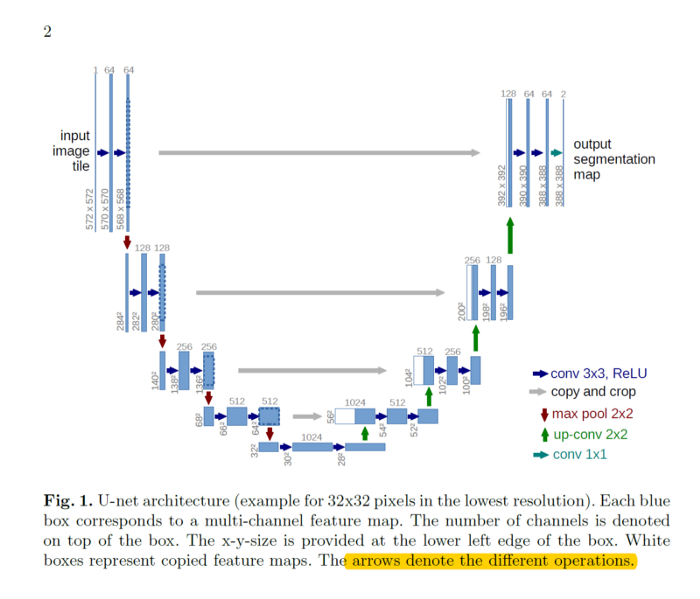


In [143]:

def model( x ) :
    batch_size = tf.shape( x )[0]
    x = tf.cast( x , dtype=tf.float32 )
    c1 = conv2d_down( x , weights[ 0 ] , stride_size=1 ) 
    c1 = conv2d_down( c1 , weights[ 1 ] , stride_size=1 ) 
    p1 = maxpool_down( c1 , pool_size=2 , stride_size=2 )
    
    c2 = conv2d_down( p1 , weights[ 2 ] , stride_size=1 )
    c2 = conv2d_down( c2 , weights[ 3 ] , stride_size=1 ) 
    p2 = maxpool_down( c2 , pool_size=2 , stride_size=2 )
    
    c3 = conv2d_down( p2 , weights[ 4 ] , stride_size=1 ) 
    c3 = conv2d_down( c3 , weights[ 5 ] , stride_size=1 ) 
    p3 = maxpool_down( c3 , pool_size=2 , stride_size=2 )
    
    c4 = conv2d_down( p3 , weights[ 6 ] , stride_size=1 )
    c4 = conv2d_down( c4 , weights[ 7 ] , stride_size=1 )
    p4 = maxpool_down( c4 , pool_size=2 , stride_size=2 )

    c5 = conv2d_down( p4 , weights[ 8 ] , stride_size=1 )
    c5 = conv2d_down( c5 , weights[ 9 ] , stride_size=1 ) 
        
    # p5 = maxpool_up( c5 , 2 )
    # concat_1 = tf.concat( [ p5 , c4 ] , axis=-1 ) 
    c6 = conv2d_up( c5 , weights[ 10 ] , stride_size=2, output_shape=[ batch_size , 16 , 16 , 128 ] )
    concat_1 = tf.concat( [ c6 , c4 ] , axis=-1 ) 

    c6 = conv2d_up( concat_1 , weights[ 11 ] , stride_size=1 , output_shape=[ batch_size , 16 , 16 , 128 ] )  

    # p6 = maxpool_up( c6 , 2 )
    c7 = conv2d_up( c6 , weights[ 12 ] , stride_size=2, output_shape=[ batch_size , 32 , 32 , 64 ] )
    concat_2 = tf.concat( [ c7 , c3 ] , axis=-1 ) 

    c7 = conv2d_up( concat_2 , weights[ 13 ] , stride_size=1 , output_shape=[ batch_size , 32 , 32 , 64 ] )  

    # p7 = maxpool_up( c7 , 2 )
    # concat_3 = tf.concat( [ c7 , c3 ] , axis=-1 ) 
    c8 = conv2d_up( c7 , weights[ 14 ] , stride_size=2, output_shape=[ batch_size , 64 , 64 , 32 ] )
    concat_3 = tf.concat( [ c8 , c2 ] , axis=-1 ) 
    c8 = conv2d_up( concat_3 , weights[ 15 ] , stride_size=1 , output_shape=[ batch_size , 64 , 64 , 32 ] )   

    # p8 = maxpool_up( c8 , 2 )
    # concat_4 = tf.concat( [ c8 , c2 ] , axis=-1 ) 
    c9 = conv2d_up( c8 , weights[ 16 ] , stride_size=2, output_shape=[ batch_size , 128 , 128 , 16 ] )
    concat_4 = tf.concat( [ c9 , c1] , axis=-1 ) 
    c9 = conv2d_up( concat_4 , weights[ 17 ] , stride_size=1 , output_shape=[ batch_size , 128 , 128 , 16 ] )   

    output = tf.nn.conv2d( c9 , weights[ 18 ] , strides=[ 1 , 1 , 1 , 1 ] ,  padding=padding ) 
    outputs = tf.nn.sigmoid( output ) 
    return outputs #tf.keras.Model(inputs=x, outputs=outputs)  #


In [144]:

def loss( pred , target ):
    
    return tf.losses.binary_crossentropy( target , pred )



def mean_iou(y_true, y_pred):
    y_true = tf.cast(y_true, tf.dtypes.float64)
    y_pred = tf.cast(y_pred, tf.dtypes.float64)
    I = tf.reduce_sum(y_pred * y_true, axis=(1, 2))
    U = tf.reduce_sum(y_pred + y_true, axis=(1, 2)) - I
    return tf.reduce_mean(I / U)


def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice = tf.reduce_mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice

optimizer = tf.optimizers.Adam( learning_rate=float( learning_rate ) )

def train( model, inputs , outputs ):
    with tf.GradientTape() as tape:
        current_loss = loss( model(inputs), outputs)
    grads = tape.gradient( current_loss , weights )
    optimizer.apply_gradients( zip( grads , weights ) )
    return tf.reduce_mean( current_loss )


In [145]:
losses = []
for e in tqdm.tqdm(range(20)):
   for features in train_dataset:
     image,label = features
     summ_loss = train(model,image,label)
     losses.append(summ_loss)



100%|██████████| 20/20 [03:33<00:00, 10.66s/it]


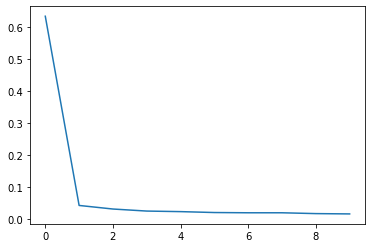

In [146]:
import matplotlib.pyplot as plt
plt.plot(losses[::250])


In [104]:
# tf.saved_model.save(model, "model.pb")

np.save('unet_lite.npy', weights) # save
# new_num_arr = np.load('weights.npy') # load

## test


In [148]:
weights = np.load('unet_lite.npy',allow_pickle=True) # load


(1, 128, 128, 3)


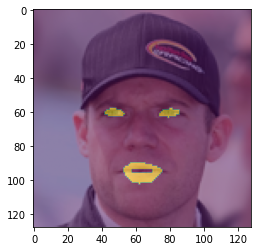

In [150]:
import matplotlib.pyplot as plt
id = 43
input_image = test_features[id-1:id]
pred = model( input_image ).numpy()
print(input_image.shape)
image = np.zeros( ( 128 , 128  ) )
for x in range( 128 ):
    for y in range( 128 ):
        if pred[ 0 , x , y ] > 0.5:
            image[ x , y ] = 255 
        else:
            image[ x , y ] =  0
show_images( [ test_features[id] , image ] )